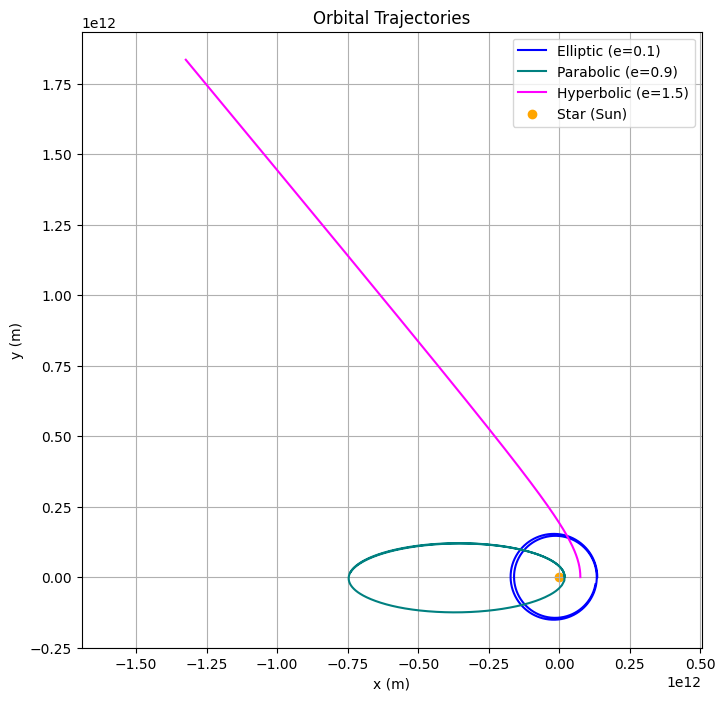

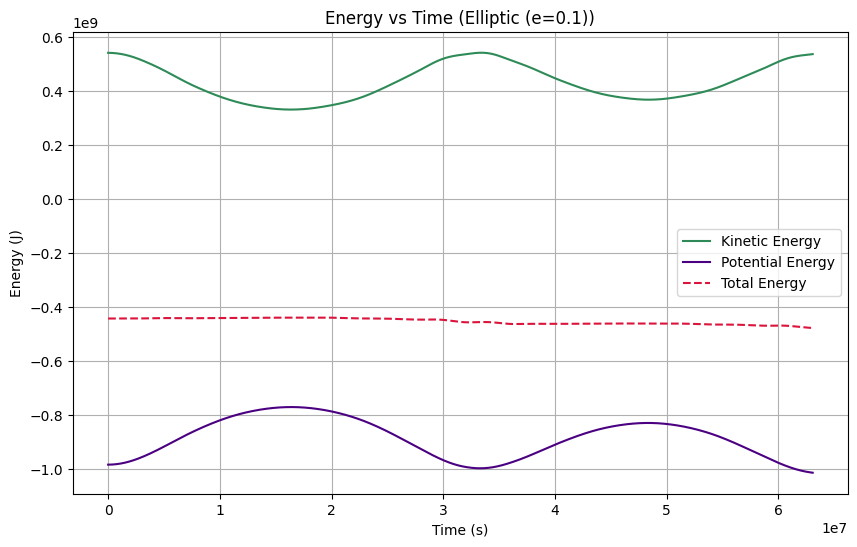

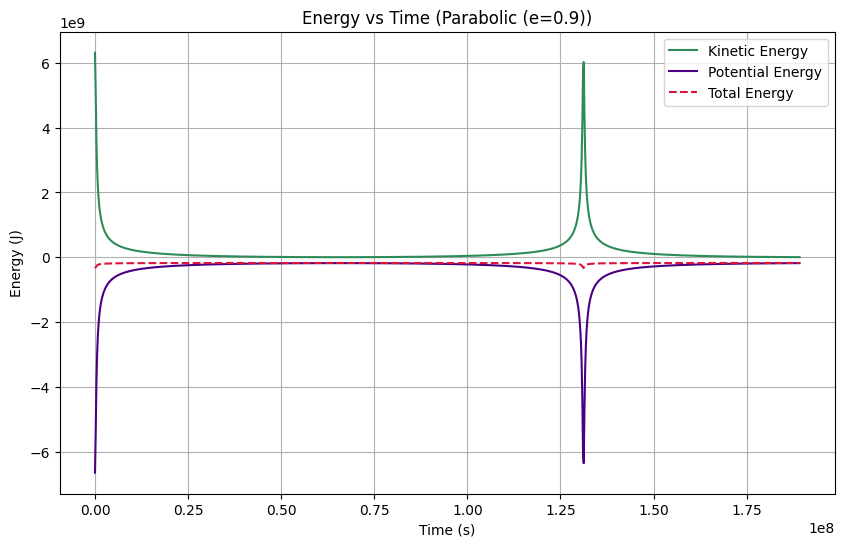

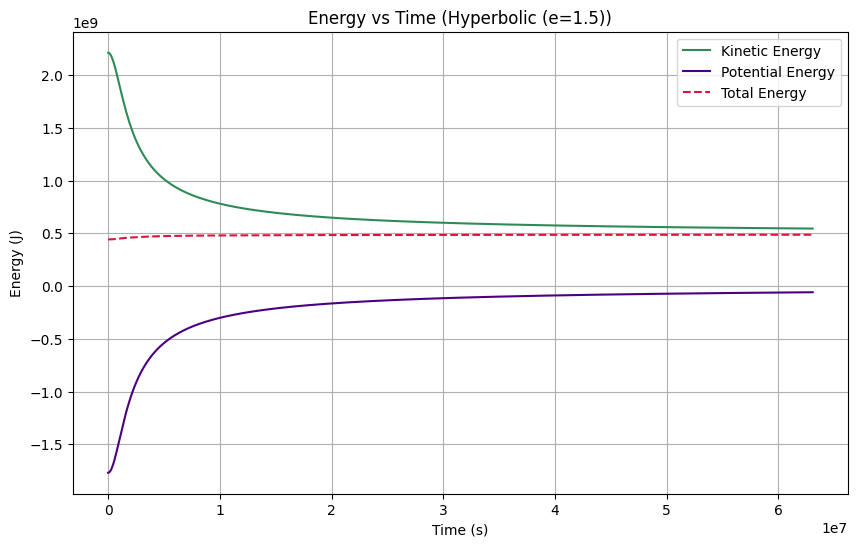

In [ ]:
# Import plotting tools for visualising orbits and energies
import matplotlib.pyplot as plt

# Import NumPy for numerical calculations
import numpy as np

# Import ODE solver for integrating equations of motion
from scipy.integrate import solve_ivp


# Define the gravitational acceleration function used by the ODE solver
# t : time (required by solve_ivp, not explicitly used)
# y : state vector [x, y, vx, vy] for each orbiting body
# M : mass of the central star
# epsilon : optional parameter (not used here)
def gravitational_acceleration(t, y, M, epsilon=0):
    G = 6.67430e-11              # Gravitational constant (SI units)
    delta = 0.001                # Small deviation from inverse-square law
    n = len(y) // 4              # Number of planets (4 variables per planet)
    dydt = []                    # List to store derivatives

    # Loop over each planet
    for i in range(n):
        x = y[4*i]               # x-position
        y_pos = y[4*i + 1]       # y-position
        vx = y[4*i + 2]          # x-velocity
        vy = y[4*i + 3]          # y-velocity

        # Radial distance from the star
        r = np.sqrt(x**2 + y_pos**2)

        # Gravitational acceleration with a small power-law modification
        acceleration_magnitude = -G * M / r**(2 + delta)

        # Resolve acceleration into x and y components
        ax = acceleration_magnitude * (x / r)
        ay = acceleration_magnitude * (y_pos / r)

        # Append time derivatives: dx/dt, dy/dt, dvx/dt, dvy/dt
        dydt.extend([vx, vy, ax, ay])

    return dydt


# Define initial conditions for different orbital eccentricities
def initial_conditions(eccentricity, semi_major_axis, M_star):
    G = 6.67430e-11  # Gravitational constant

    # Elliptical orbit (bound)
    if eccentricity < 1.0:
        r_perihelion = semi_major_axis * (1 - eccentricity)
        v_perihelion = np.sqrt(G * M_star * (2 / r_perihelion - 1 / semi_major_axis))
        return [r_perihelion, 0, 0, v_perihelion]

    # Parabolic orbit (critical escape)
    elif eccentricity == 1.0:
        r_perihelion = semi_major_axis
        v_perihelion = np.sqrt(G * M_star / r_perihelion)
        return [r_perihelion, 0, 0, v_perihelion]

    # Hyperbolic orbit (unbound)
    else:
        r_perihelion = semi_major_axis * (eccentricity - 1)
        v_perihelion = np.sqrt(G * M_star / r_perihelion * (eccentricity + 1))
        return [r_perihelion, 0, 0, v_perihelion]


# Compute kinetic, potential, and total energy for each orbit over time
def compute_energies(solution, M_star, epsilon=0):
    G = 6.67430e-11
    energies = {"kinetic": [], "potential": [], "total": []}
    n = len(solution) // 4       # Number of planets

    # Loop over each time step
    for t_idx in range(solution.shape[1]):
        kinetic, potential = 0, 0

        # Sum energies for each planet
        for i in range(n):
            x, y, vx, vy = solution[4*i:4*(i+1), t_idx]
            r = np.sqrt(x**2 + y**2)

            # Kinetic energy per unit mass
            kinetic += 0.5 * (vx**2 + vy**2)

            # Gravitational potential energy per unit mass
            potential += -G * M_star / r**(1 + epsilon)

        # Total mechanical energy
        total = kinetic + potential

        energies["kinetic"].append(kinetic)
        energies["potential"].append(potential)
        energies["total"].append(total)

    return energies


# -----------------------------
# Simulation parameters
# -----------------------------

# Mass of the central star (Sun) in kg
M_star = 1.989e30

# Semi-major axes for the three orbits
semi_major_axes = [1.5e11, 2.0e11, 1.5e11]

# Orbital eccentricities: elliptic, near-parabolic, hyperbolic
eccentricities = [0.1, 0.9, 1.5]

# Generate initial state vectors for each orbit
initial_states = [initial_conditions(e, a, M_star) for e, a in zip(eccentricities, semi_major_axes)]


# Define individual integration time spans for each orbit
time_spans = [
    (0, (3.1536e7)*2),  # Elliptical orbit
    (0, (3.1536e7)*6),  # Near-parabolic orbit
    (0, (3.1536e7)*2)   # Hyperbolic orbit
]

# Generate time arrays for numerical integration
time_eval_sets = [np.linspace(t[0], t[1], 1000) for t in time_spans]


# -----------------------------
# Orbit simulation
# -----------------------------

results = []

# Integrate equations of motion for each orbit
for initial_state, time_span, time_eval in zip(initial_states, time_spans, time_eval_sets):
    initial_state_flat = np.array(initial_state).flatten()
    sol = solve_ivp(
        gravitational_acceleration,
        t_span=time_span,
        y0=initial_state_flat,
        t_eval=time_eval,
        args=(M_star, 0.0)
    )
    results.append(sol)


# -----------------------------
# Plot orbital trajectories
# -----------------------------

plt.figure(figsize=(8, 8))

# Define colours and labels for each orbit
colors = ["blue", "teal", "magenta"]
labels = ["Elliptic (e=0.1)", "Parabolic (e=0.9)", "Hyperbolic (e=1.5)"]

# Plot each orbit trajectory
for i, sol in enumerate(results):
    plt.plot(sol.y[0], sol.y[1], color=colors[i], label=labels[i])

# Plot the central star
plt.scatter(0, 0, color="orange", label="Star (Sun)")

plt.title("Orbital Trajectories")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.axis("equal")
plt.legend()
plt.grid()
plt.show()


# -----------------------------
# Energy analysis
# -----------------------------

# Compute and plot energy evolution for each orbit
for i, sol in enumerate(results):
    energies = compute_energies(sol.y, M_star, 0.0)

    plt.figure(figsize=(10, 6))
    plt.plot(time_eval_sets[i], energies["kinetic"], label="Kinetic Energy", color="seagreen")
    plt.plot(time_eval_sets[i], energies["potential"], label="Potential Energy", color="indigo")
    plt.plot(time_eval_sets[i], energies["total"], label="Total Energy", color="crimson", linestyle="--")

    plt.title(f"Energy vs Time ({labels[i]})")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (J)")
    plt.legend()
    plt.grid()
    plt.show()


Animation saved as 'three_body_system_with_eccentricity0.5.gif'


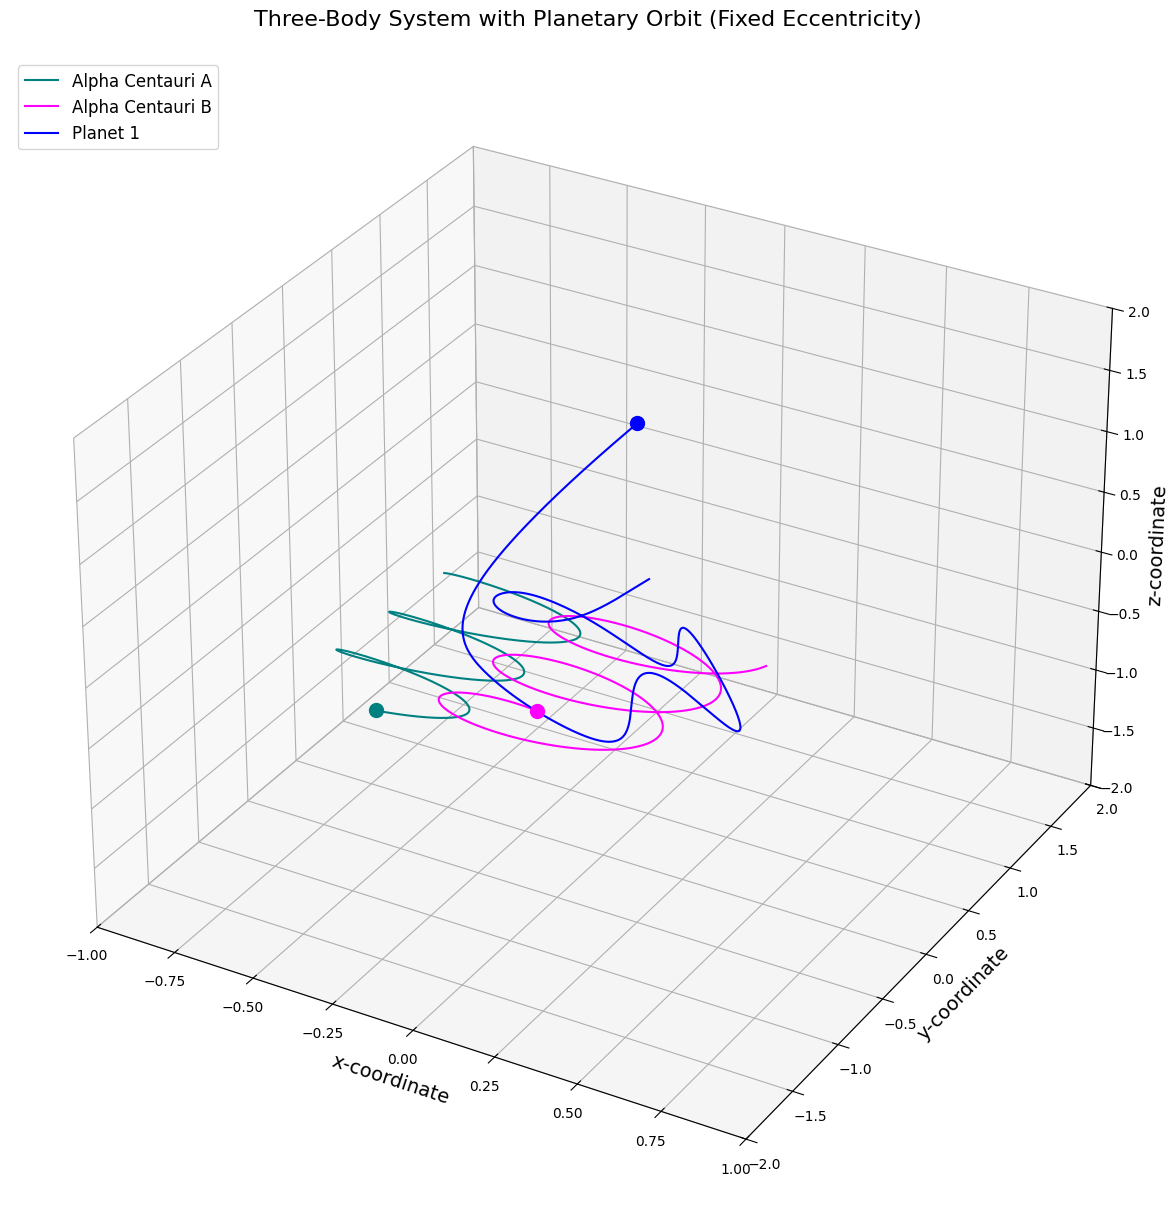

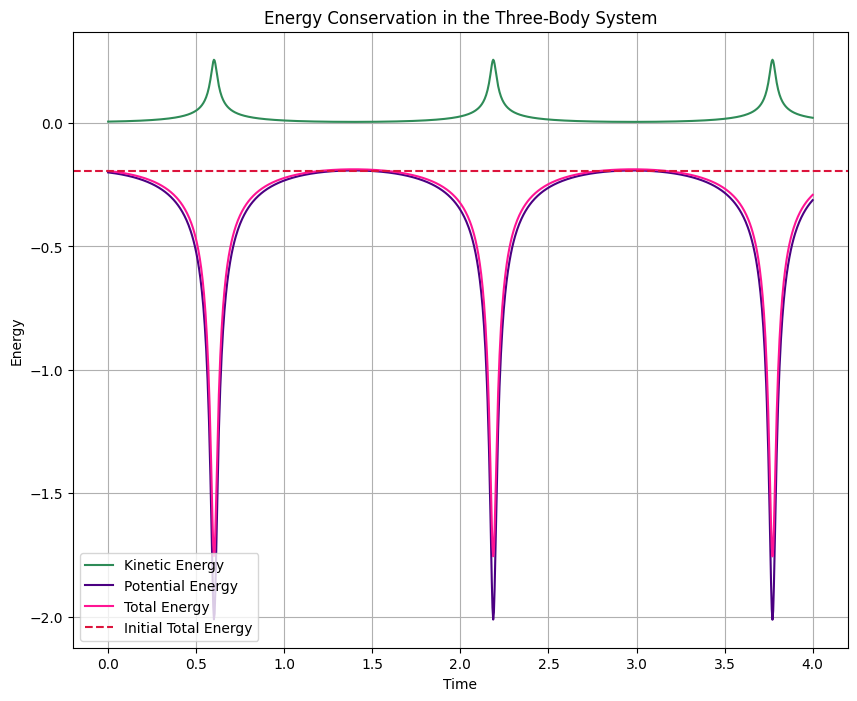

In [ ]:
# Import numerical and plotting libraries
import numpy as np
import matplotlib.pyplot as plt

# Tools for 3D plotting
from mpl_toolkits.mplot3d import Axes3D

# ODE solver for systems of differential equations
from scipy.integrate import odeint

# Animation tools for saving orbital motion as a GIF
from matplotlib.animation import FuncAnimation, PillowWriter


# -----------------------------
# Physical constants
# -----------------------------

# Universal gravitational constant (SI units)
G = 6.67408e-11  # N m^2 kg^-2


# -----------------------------
# Reference (normalisation) quantities
# -----------------------------

# Mass scale: mass of the Sun
m_nd = 1.989e+30  # kg

# Distance scale: separation of Alpha Centauri A and B
r_nd = 5.326e+12  # m

# Velocity scale: typical orbital velocity
v_nd = 30000  # m/s

# Time scale: orbital period of Alpha Centauri (scaled)
t_nd = 79.91 * 365 * 24 * 3600 * 0.51  # s


# -----------------------------
# Dimensionless constants
# -----------------------------

# These constants rescale the equations into dimensionless form
K1 = G * t_nd * m_nd / (r_nd**2 * v_nd)
K2 = v_nd * t_nd / r_nd


# -----------------------------
# Masses (in solar-mass units)
# -----------------------------

m1 = 1.1        # Alpha Centauri A
m2 = 0.907      # Alpha Centauri B
m3 = 3.003e-6   # Planet (Earth-like mass)


# -----------------------------
# Initial positions
# -----------------------------

# Initial position vectors (dimensionless units)
r1 = [-0.5, 0, 0]   # Alpha Centauri A
r2 = [0.5, 0, 0]    # Alpha Centauri B
r3 = [0, 0.5, 0]    # Planet


# -----------------------------
# Orbital parameters
# -----------------------------

# Orbital eccentricity of the planet
eccentricity = 0.9

# Semi-major axis (normalised units)
a = 1

# Periapsis and apoapsis distances
r_periapsis = a * (1 - eccentricity)
r_apoapsis = a * (1 + eccentricity)


# -----------------------------
# Velocity via vis-viva equation
# -----------------------------

def velocity_at_radius(a, eccentricity, r):
    # Vis-viva equation for orbital speed
    return np.sqrt(G * (m1 + m2 + m3) * (2/r - 1/a))


# Initial radial distance of the planet
r = np.linalg.norm(r3)

# Initial velocity magnitude
v3 = velocity_at_radius(a, eccentricity, r)

# Assume initial velocity is along the y-direction
v_x = 0
v_y = np.sqrt(G * (m1 + m2 + m3) * (2/r - 1/a))
v3 = np.array([v_x, v_y, 0])


# -----------------------------
# Initial velocities of stars
# -----------------------------

r3 = [0, 0.5, 0]
v1 = [0.01, 0.01, 0]
v2 = [-0.05, 0, -0.1]


# Convert all positions and velocities to NumPy arrays
r1 = np.array(r1, dtype="float64")
r2 = np.array(r2, dtype="float64")
r3 = np.array(r3, dtype="float64")
v1 = np.array(v1, dtype="float64")
v2 = np.array(v2, dtype="float64")
v3 = np.array(v3, dtype="float64")


# -----------------------------
# Three-body equations of motion
# -----------------------------

def ThreeBodyEquations(w, t, G, m1, m2, m3):
    # Unpack positions
    r1 = w[:3]
    r2 = w[3:6]
    r3 = w[6:9]

    # Unpack velocities
    v1 = w[9:12]
    v2 = w[12:15]
    v3 = w[15:18]

    # Small deviation from inverse-square law
    delta = 0.001

    # Pairwise distances
    r12 = np.linalg.norm(r2 - r1)
    r13 = np.linalg.norm(r3 - r1)
    r23 = np.linalg.norm(r3 - r2)

    # Accelerations with modified gravity (r^-(2+delta))
    dv1bydt = K1 * m2 * (r2 - r1) / r12**(3 + delta) + K1 * m3 * (r3 - r1) / r13**(3 + delta)
    dv2bydt = K1 * m1 * (r1 - r2) / r12**(3 + delta) + K1 * m3 * (r3 - r2) / r23**(3 + delta)
    dv3bydt = K1 * m1 * (r1 - r3) / r13**(3 + delta) + K1 * m2 * (r2 - r3) / r23**(3 + delta)

    # Position derivatives
    dr1bydt = K2 * v1
    dr2bydt = K2 * v2
    dr3bydt = K2 * v3

    # Combine derivatives into one array
    r_derivs = np.concatenate((dr1bydt, dr2bydt, dr3bydt))
    v_derivs = np.concatenate((dv1bydt, dv2bydt, dv3bydt))
    derivs = np.concatenate((r_derivs, v_derivs))

    return derivs


# -----------------------------
# Energy calculation
# -----------------------------

def compute_energies(positions, velocities, m1, m2, m3):
    r1, r2, r3 = positions
    v1, v2, v3 = velocities

    # Kinetic energy
    kinetic_energy = (
        0.5 * m1 * np.linalg.norm(v1)**2 +
        0.5 * m2 * np.linalg.norm(v2)**2 +
        0.5 * m3 * np.linalg.norm(v3)**2
    )

    # Distances
    r12 = np.linalg.norm(r2 - r1)
    r13 = np.linalg.norm(r3 - r1)
    r23 = np.linalg.norm(r3 - r2)

    # Gravitational potential energy
    potential_energy = -K1 * (
        m1 * m2 / r12 +
        m1 * m3 / r13 +
        m2 * m3 / r23
    )

    return kinetic_energy, potential_energy


# -----------------------------
# Time integration
# -----------------------------

# Initial state vector
init_params = np.array([r1, r2, r3, v1, v2, v3]).flatten()

# Time grid
time_span = np.linspace(0, 4, 1000)

# Solve the three-body system
solution = odeint(ThreeBodyEquations, init_params, time_span, args=(G, m1, m2, m3))


# -----------------------------
# Extract solutions
# -----------------------------

r1_sol = solution[:, 0:3]
r2_sol = solution[:, 3:6]
r3_sol = solution[:, 6:9]
v1_sol = solution[:, 9:12]
v2_sol = solution[:, 12:15]
v3_sol = solution[:, 15:18]


# -----------------------------
# Energy tracking
# -----------------------------

kinetic_energies = np.zeros(len(time_span))
potential_energies = np.zeros(len(time_span))
total_energies = np.zeros(len(time_span))

for i in range(len(time_span)):
    kinetic_energies[i], potential_energies[i] = compute_energies(
        [r1_sol[i], r2_sol[i], r3_sol[i]],
        [v1_sol[i], v2_sol[i], v3_sol[i]],
        m1, m2, m3
    )
    total_energies[i] = kinetic_energies[i] + potential_energies[i]


# -----------------------------
# 3D animation
# -----------------------------

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection="3d")

line1, = ax.plot([], [], [], color="teal", label="Alpha Centauri A")
line2, = ax.plot([], [], [], color="magenta", label="Alpha Centauri B")
line3, = ax.plot([], [], [], color="blue", label="Planet 1")

point1 = ax.scatter([], [], [], color="teal", s=100)
point2 = ax.scatter([], [], [], color="magenta", s=100)
point3 = ax.scatter([], [], [], color="blue", s=100)

ax.set_xlabel("x-coordinate")
ax.set_ylabel("y-coordinate")
ax.set_zlabel("z-coordinate")
ax.set_title("Three-Body System with Planetary Orbit (Fixed Eccentricity)")
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-2, 2)
ax.set_zlim3d(-2, 2)
ax.legend()
ax.grid()


def update(frame):
    # Update orbit traces
    line1.set_data(r1_sol[:frame, 0], r1_sol[:frame, 1])
    line1.set_3d_properties(r1_sol[:frame, 2])

    line2.set_data(r2_sol[:frame, 0], r2_sol[:frame, 1])
    line2.set_3d_properties(r2_sol[:frame, 2])

    line3.set_data(r3_sol[:frame, 0], r3_sol[:frame, 1])
    line3.set_3d_properties(r3_sol[:frame, 2])

    # Update body positions
    point1._offsets3d = ([r1_sol[frame, 0]], [r1_sol[frame, 1]], [r1_sol[frame, 2]])
    point2._offsets3d = ([r2_sol[frame, 0]], [r2_sol[frame, 1]], [r2_sol[frame, 2]])
    point3._offsets3d = ([r3_sol[frame, 0]], [r3_sol[frame, 1]], [r3_sol[frame, 2]])

    return line1, line2, line3, point1, point2, point3


# Create and save animation
anim = FuncAnimation(fig, update, frames=len(time_span), interval=20, blit=False)
writer = PillowWriter(fps=50)
anim.save("three_body_system_with_eccentricity0.5.gif", writer=writer)

print("Animation saved as 'three_body_system_with_eccentricity0.5.gif'")


# -----------------------------
# Energy conservation plot
# -----------------------------

plt.figure(figsize=(10, 8))
plt.plot(time_span, kinetic_energies, label="Kinetic Energy", color="seagreen")
plt.plot(time_span, potential_energies, label="Potential Energy", color="indigo")
plt.plot(time_span, total_energies, label="Total Energy", color="deeppink")
plt.axhline(total_energies[0], color="crimson", linestyle="--", linewidth=1.5,
            label="Initial Total Energy")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy Conservation in the Three-Body System")
plt.legend()
plt.grid()
plt.show()
